In [1]:
# check likelihood for different cosmo params -- vary w and wa separately while keeping others fixed

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sacc
import pyccl as ccl
import firecrown.likelihood.gauss_family.statistic.source.weak_lensing as wl
import firecrown.likelihood.gauss_family.statistic.source.number_counts as nc
from firecrown.likelihood.gauss_family.statistic.two_point import TwoPoint
from firecrown.likelihood.gauss_family.gaussian import ConstGaussian
from firecrown.modeling_tools import ModelingTools
from firecrown.parameters import ParamsMap

In [3]:
# cosmological parameters from CosmoLike DESC SRD
srd_fid_params = {'h': 0.6727,
                  'Omega_c': 0.2664315,
                  'Omega_b': 0.0491685,
                  'Omega_k': 0.0,
                  'w0': -1.0,
                  'wa': 0.0,
                  'sigma8': 0.831,
                  'n_s': 0.9645 }

# linear galaxy bias for LSST Y1's 5 redshift bins from the DESC SRD
systematics_params = ParamsMap(
        {
            "lens0_bias": 1.562362,
            "lens1_bias": 1.732963,
            "lens2_bias": 1.913252,
            "lens3_bias": 2.100644,
            "lens4_bias": 2.293210,
        }
    )

In [4]:
def build_likelihood(_):
    """Create a firecrown likelihood for an SRD-like galaxy clustering analysis.
    No systematics yet apart from linear bias. 
    Based on DES 3x2pt example in firecrown"""
    
    sources: Dict[str, nc.NumberCounts] = {}
        
    for i in range(5):
        sources[f"lens{i}"] = nc.NumberCounts(
            sacc_tracer=f"lens{i}"
        )

    # Now that we have all sources we can instantiate all the two-point
    # functions. For each one we create a new two-point function object.
    stats = {}
    for i in range(5):
        stats[f"ell_cl_lens{i}_lens{i}"] = TwoPoint(
            source0=sources[f"lens{i}"],
            source1=sources[f"lens{i}"],
            sacc_data_type="galaxy_density_cl",
        )

    # Here we instantiate the actual likelihood. The statistics argument carry
    # the order of the data/theory vector.
    modeling_tools = ModelingTools()
    likelihood = ConstGaussian(statistics=list(stats.values()))

    # We load the correct SACC file.
    saccfile = "lsst_y1_desc_srd_sacc.fits"
    sacc_data = sacc.Sacc.load_fits(saccfile)

    likelihood.read(sacc_data)
    
    print(
        "Using parameters:", list(likelihood.required_parameters().get_params_names())
    )

    # This script will be loaded by the appropriated connector. The framework
    # will call the factory function that should return a Likelihood instance.
    return likelihood, modeling_tools

Using parameters: ['lens4_bias', 'lens3_bias', 'lens2_bias', 'lens1_bias', 'lens0_bias']
Log-like = -0.00000


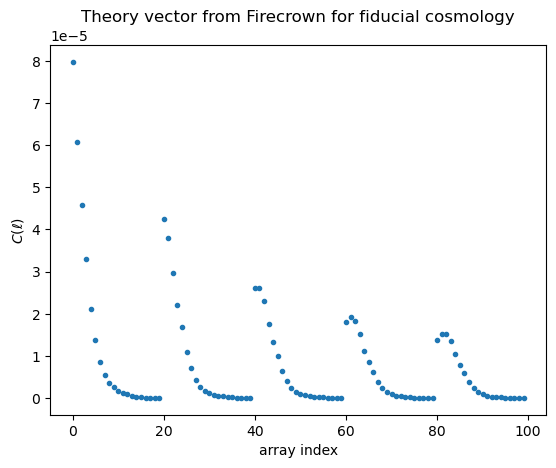

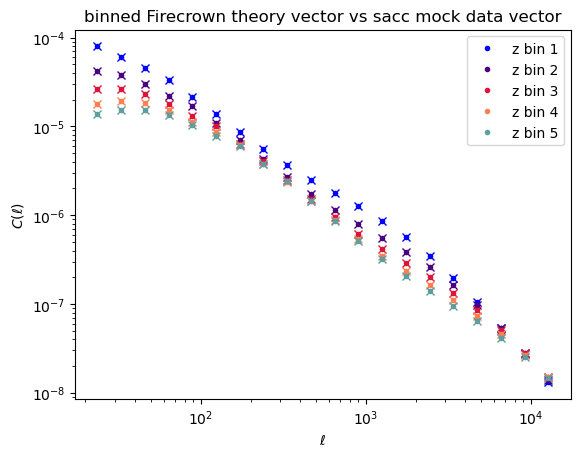

In [5]:
saccfile = "lsst_y1_desc_srd_sacc.fits"
sacc_data = sacc.Sacc.load_fits(saccfile)

likelihood, tools = build_likelihood(None)
likelihood.update(systematics_params)

cosmo_fid = ccl.Cosmology(w0 = srd_fid_params['w0'],
                             wa = srd_fid_params['wa'],
                             Omega_c = srd_fid_params['Omega_c'],
                             Omega_b = srd_fid_params['Omega_b'],
                             Omega_k = srd_fid_params['Omega_k'],
                             sigma8 = srd_fid_params['sigma8'],
                             n_s = srd_fid_params['n_s'],
                             h = srd_fid_params['h']
                            )
cosmo_fid.compute_nonlin_power()
tools.prepare(cosmo_fid)
loglike = likelihood.compute_loglike(tools)
print(f"Log-like = {loglike:.5f}")
cl_th_fc_fid = likelihood.compute_theory_vector(tools)
plt.plot(cl_th_fc_fid, '.')
plt.xlabel('array index')
plt.ylabel(r'$C(\ell)$')
plt.title('Theory vector from Firecrown for fiducial cosmology')
plt.show() 

nbinz = 5
nbinl = 20
colors=['blue', 'indigo', 'crimson', 'coral', 'cadetblue']
for i in range(nbinz):
    l_sacc, cl_gg_sacc= sacc_data.get_ell_cl('galaxy_density_cl', 'lens%d'%i, 'lens%d'%i)
    plt.loglog(l_sacc, cl_th_fc_fid[i*nbinl:(i+1)*nbinl], '.', color=colors[i], label='z bin %d'%(i+1))
    plt.loglog(l_sacc, cl_gg_sacc, 'x', color=colors[i])
plt.title("binned Firecrown theory vector vs sacc mock data vector")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C(\ell)$')
plt.legend()
plt.show()

In [6]:
def get_loglike_vs_w0_slice(w0_arr):
    n = len(w0_arr)
    loglikes_w0_arr = np.zeros(n)
    colors = plt.cm.spring(np.linspace(0,1,n))
    i_plot = np.arange(0, n, 5)
    for i, w0 in enumerate(w0_arr):
        print(i, w0)
        likelihood, tools = build_likelihood(None)
        likelihood.update(systematics_params)

        cosmo_w0 = ccl.Cosmology(w0 = w0,
                                 wa = srd_fid_params['wa'],
                                 Omega_c = srd_fid_params['Omega_c'],
                                 Omega_b = srd_fid_params['Omega_b'],
                                 Omega_k = srd_fid_params['Omega_k'],
                                 sigma8 = srd_fid_params['sigma8'],
                                 n_s = srd_fid_params['n_s'],
                                 h = srd_fid_params['h']
                                )
        cosmo_w0.compute_nonlin_power()
        tools.prepare(cosmo_w0)
        loglikes_w0_arr[i] = likelihood.compute_loglike(tools)
        print(f"Log-like = {loglikes_w0_arr[i]:.1f}")

        cl_th_fc = likelihood.compute_theory_vector(tools)
        # To do: don't plot/label every w0 value, use a more sequential colormap
        #plt.plot(cl_th_fc, '.', label = 'w0=%f'%np.round(w0,5), color=colors[i])
        if i in i_plot:
            plt.plot((cl_th_fc-cl_th_fc_fid)/cl_th_fc_fid, '.', label = 'w0=%.4f'%w0, color=colors[i])
    plt.legend()
    plt.xlabel('array index')
    plt.ylabel(r'$\Delta C(\ell)/C(\ell)$')
    plt.title('Fractional difference: theory vector from Firecrown for varied w0 vs fiducial cosmology')
    plt.show()  
    
    return loglikes_w0_arr
    

0 -1.001
Using parameters: ['lens4_bias', 'lens3_bias', 'lens2_bias', 'lens1_bias', 'lens0_bias']
Log-like = -10.3
1 -1.0009
Using parameters: ['lens4_bias', 'lens3_bias', 'lens2_bias', 'lens1_bias', 'lens0_bias']
Log-like = -8.4
2 -1.0008
Using parameters: ['lens4_bias', 'lens3_bias', 'lens2_bias', 'lens1_bias', 'lens0_bias']
Log-like = -6.6
3 -1.0007
Using parameters: ['lens4_bias', 'lens3_bias', 'lens2_bias', 'lens1_bias', 'lens0_bias']
Log-like = -5.1
4 -1.0006
Using parameters: ['lens4_bias', 'lens3_bias', 'lens2_bias', 'lens1_bias', 'lens0_bias']
Log-like = -3.7
5 -1.0005
Using parameters: ['lens4_bias', 'lens3_bias', 'lens2_bias', 'lens1_bias', 'lens0_bias']
Log-like = -2.6
6 -1.0004
Using parameters: ['lens4_bias', 'lens3_bias', 'lens2_bias', 'lens1_bias', 'lens0_bias']
Log-like = -1.7
7 -1.0003
Using parameters: ['lens4_bias', 'lens3_bias', 'lens2_bias', 'lens1_bias', 'lens0_bias']
Log-like = -0.9
8 -1.0002
Using parameters: ['lens4_bias', 'lens3_bias', 'lens2_bias', 'lens1_bi

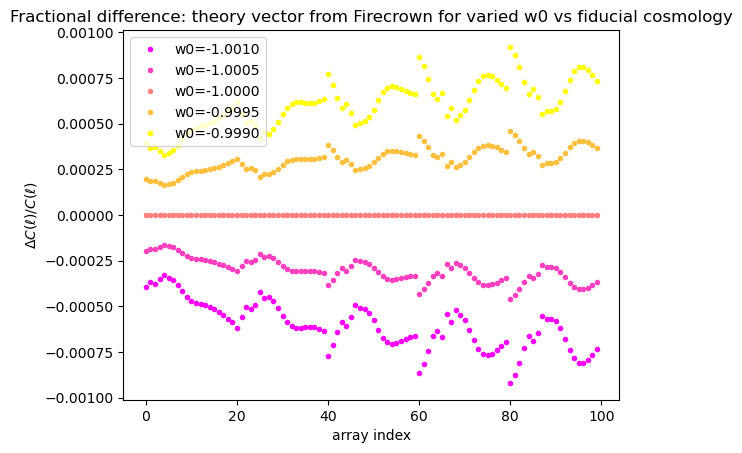

In [7]:
n=21
w0_arr = np.linspace(-1.001, -0.999, n)
loglikes_w0_arr = get_loglike_vs_w0_slice(w0_arr)

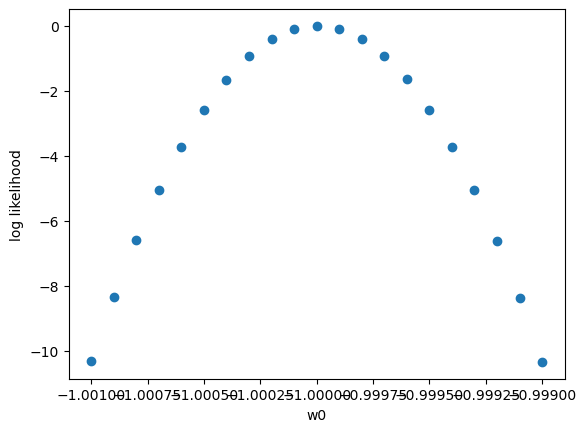

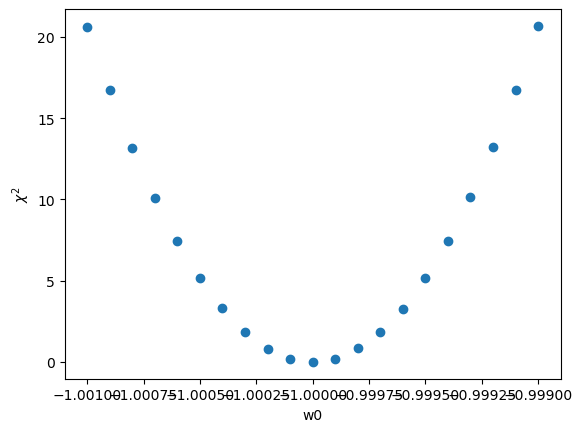

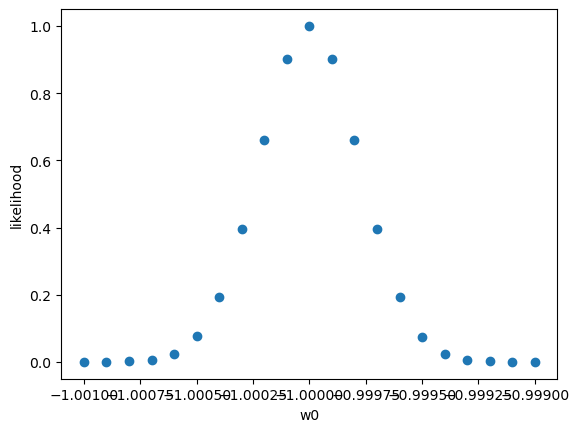

In [8]:
plt.scatter(w0_arr, loglikes_w0_arr)
plt.xlabel('w0')
plt.ylabel('log likelihood')
plt.show()

plt.scatter(w0_arr, -2*loglikes_w0_arr)
plt.xlabel('w0')
plt.ylabel(r'$\chi^2$')
plt.show()

plt.scatter(w0_arr, np.exp(loglikes_w0_arr))
plt.xlabel('w0')
plt.ylabel('likelihood')
plt.show()